# Task1:代码复现

## 时序数据生成&处理

### 绘制序列

In [1]:
# 导入库
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
import torch.nn.functional as F
torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
# 定义绘制函数
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    # 设置图例
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

### 趋势、噪声的生成函数

In [3]:
# 趋势模式的生成函数
def trend(time, slope=0):
    # 序列和时间成线性关系
    return slope * time

In [4]:
# 噪声模式的生成函数
def white_noise(time, noise_level=1, seed=None):
    # 生成正态分布的伪随机数序列
    rnd = np.random.RandomState(seed)
    # 生成随机数，noise_level为控制噪声幅度大小
    return rnd.randn(len(time)) * noise_level

### 季节性的生成函数

In [5]:
# 季节性模式的生成函数
def seasonal_pattern(season_time):
    # np.where(condition, x, y) 满足条件(condition)，输出x，不满足输出y
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

# 将某个季节性模式进行重复
def seasonality(time, period, amplitude=1, phase=0):
    # 将时间映射到0-1之间
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

### 划分训练集、测试集、batch

In [24]:
def train_test_split(series, split_prop): # split_prop: 训练集占比 
    train = series[:int(len(series)*split_prop)]
    test = series[int(len(series)*split_prop):]
    return train, test

# 将数据划分为指定大小的batch
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)

### 滑窗、划分特征/标签函数

In [79]:
# 滑窗、打乱
def data_process(train, test, window_size):
    # 将数据转为tensor，并进行滑窗，得到短序列
    train_tensor = torch.from_numpy(train)
    print('滑窗之前：', train_tensor.shape)
    train_window_split = train_tensor.unfold(0, window_size, 1)
    print('滑窗之后：', train_window_split.shape)
    train_set = train_window_split.numpy()

    test_tensor = torch.from_numpy(test)
    test_window_split = test_tensor.unfold(0, window_size, 1)
    test_set = test_window_split.numpy()

    # 打乱训练集数据
    train_temp1 = train_set.tolist()
    random.shuffle(train_temp1)
    train_templ2 = np.array(train_temp1)

    # 将短序列分为feature、label
    train_feature_array = train_templ2[:, :window_size-1]
    train_label_array = train_templ2[:, window_size-1:]
    test_feature_array = test_set[:, :window_size-1]
    test_label_array = test_set[:, window_size-1:]

    # 将 ndarray转为tensor
    train_feature_tensor = torch.from_numpy(train_feature_array)
    train_label = torch.from_numpy(train_label_array)
    test_feature_tensor = torch.from_numpy(test_feature_array)
    test_label = torch.from_numpy(test_label_array)

    # 扩展数据维度，符合 CNN 输入(样本数，通道数，特征数)
    train_feature = train_feature_tensor.reshape(train_feature_tensor.shape[0], 1, train_feature_tensor.shape[1])
    test_feature = test_feature_tensor.reshape(test_feature_tensor.shape[0], 1, test_feature_tensor.shape[1])

    return train_feature, train_label, test_feature, test_label

### 生成混合模式的时序数据

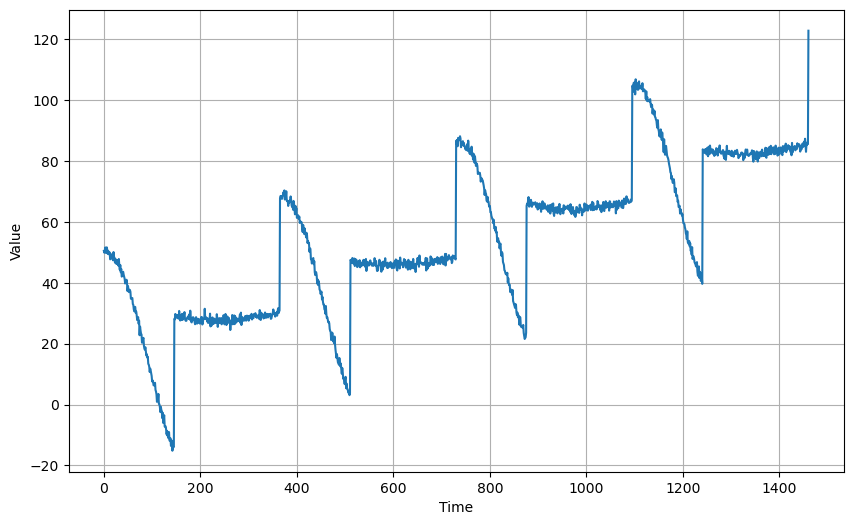

In [26]:
# 生成序列并绘制图像
time = np.arange(4 * 365 + 1)
baseline = 10
slope = 0.05
amplitude = 40
noise_level = 1
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude) + white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

### 数据处理

In [78]:
split_prop = 0.7
train, test = train_test_split(series, split_prop)
window_size = 6
# 数据处理
train_feature, train_label, test_feature, test_label = data_process(train, test, window_size)
# 分别输出训练集、测试集的特征和标签
print(train_feature.shape)
print(train_label.shape)
print(test_feature.shape)
print(test_label.shape)

torch.Size([3035, 5])
torch.Size([3035, 1, 5])
torch.Size([3035, 1])
torch.Size([1299, 1, 5])
torch.Size([1299, 1])


## CNN-模拟数据回归

### 构建一维卷积神经网络

In [34]:
# 定义卷积神经网络
class ConvModule1(nn.Module):
    def __init__(self):
        super(ConvModule1, self).__init__()
        # 一层一维卷积
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        # 将输出通道变为单值
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        out = self.conv1(x) # 一维卷积
        out = F.avg_pool1d(out, 2) # 一维平均池化
        out = self.conv2(out) # 一维卷积
        out = F.avg_pool1d(out, 2) # 一维平均池化
        out = out.squeeze()
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
# 构建网络
net = ConvModule1()

In [35]:
# 定义损失函数-均方误差
def square_loss(feature, label):
    return (net(feature) - label)**2/2

### 参数初始化

In [36]:
for params in net.parameters():
    nn.init.normal_(params, mean=0, std=0.01)

lr = 0.0005
num_epochs = 200
batch_size = 128
loss = square_loss
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

### 训练模型

In [37]:
train_loss, test_loss = [], []
# 模型训练
for epoch in range(num_epochs):
    train_l, test_l = 0.0, 0.0
    for X,y in data_iter(batch_size, train_feature, train_label):
        l = loss(X, y).sum() # 计算 loss
        # 梯度清零
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        l.backward() # 反向传播
        optimizer.step() # 更新参数
    
    train_l = loss(train_feature, train_label).mean().item()
    test_l = loss(test_feature, test_label).mean().item()
    train_loss.append(train_l)
    test_loss.append(test_l)
    print('epoch %d, train loss: %f, test loss: %f' % (epoch+1, train_l, test_l))

epoch 1, train loss: 1132.925373, test loss: 3205.103282
epoch 2, train loss: 1130.563295, test loss: 3198.732620
epoch 3, train loss: 1122.485978, test loss: 3176.296890
epoch 4, train loss: 1099.470810, test loss: 3111.749146
epoch 5, train loss: 1044.072524, test loss: 2955.749925
epoch 6, train loss: 928.513145, test loss: 2629.549297
epoch 7, train loss: 720.283906, test loss: 2040.485724
epoch 8, train loss: 414.600666, test loss: 1173.023547
epoch 9, train loss: 106.203334, test loss: 290.888624
epoch 10, train loss: 19.127559, test loss: 26.038997
epoch 11, train loss: 45.735060, test loss: 95.132739
epoch 12, train loss: 13.828881, test loss: 14.137456
epoch 13, train loss: 17.108235, test loss: 28.502421
epoch 14, train loss: 14.922953, test loss: 21.474825
epoch 15, train loss: 12.938258, test loss: 13.226398
epoch 16, train loss: 13.228681, test loss: 13.527998
epoch 17, train loss: 12.751723, test loss: 13.385921
epoch 18, train loss: 12.773361, test loss: 14.208718
epoch 

### 绘制损失函数曲线

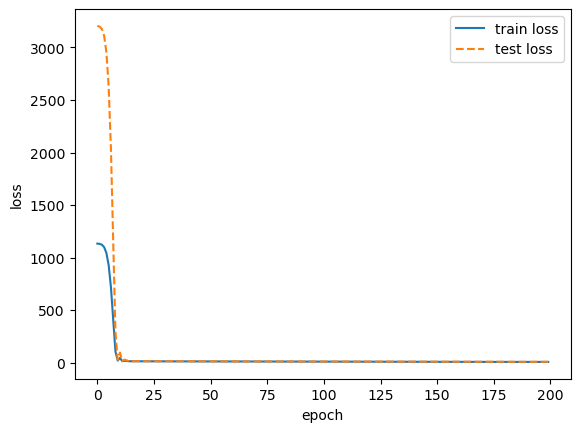

In [38]:
x = np.arange(num_epochs)
plt.plot(x, train_loss, label='train loss')
plt.plot(x, test_loss, label='test loss', linestyle='--')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

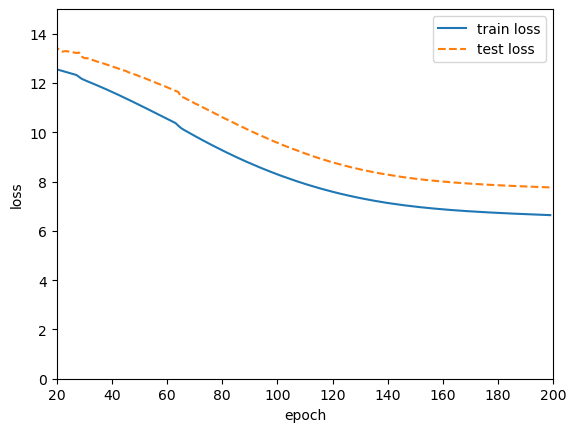

In [39]:
# 绘制局部loss曲线
x = np.arange(num_epochs)
plt.plot(x, train_loss, label='train loss')
plt.plot(x, test_loss, label='test loss', linestyle='--')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.xlim(20, num_epochs)
plt.ylim(0, 15)
plt.show()

### 预测并对比

In [ ]:
def predict(x):
    temp = torch.from_numpy(x)
    x_tensor = temp.reshape(1, 1, window_size-1) # 一次只输入一个样本
    return net(x_tensor)

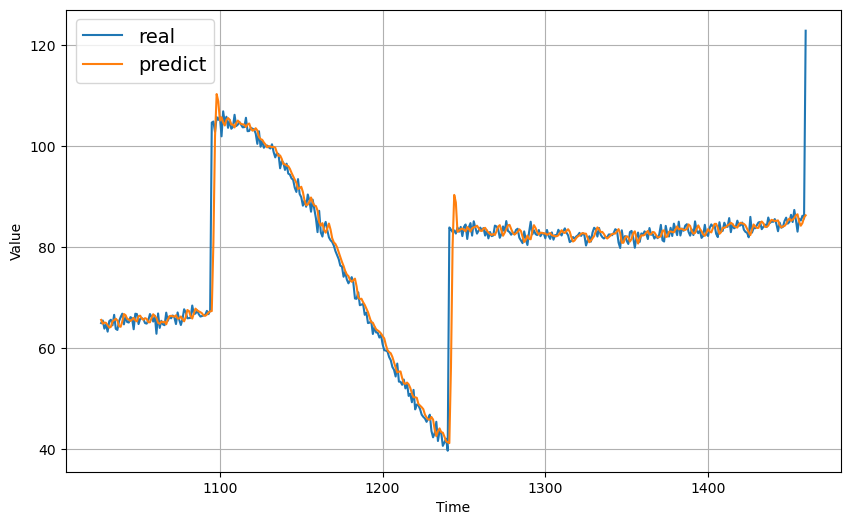

In [40]:
test_predict = []
split_point = int(split_prop * len(series))
test_time = time[split_point+window_size-1:] # 测试集时间 
test_true = series[split_point+window_size-1:] # 测试集真实值
test_predict = net(test_feature).squeeze().tolist() # 测试集预测值

plt.figure(figsize=(10, 6))
plot_series(test_time, test_true, label='real')
plot_series(test_time, test_predict, label='predict')
plt.show()

### 与使用最大池化比较

In [41]:
# 定义卷积神经网络
class ConvModule1(nn.Module):
    def __init__(self):
        super(ConvModule1, self).__init__()
        # 一层一维卷积
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        # 将输出通道变为单值
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        out = self.conv1(x) # 一维卷积
        out = F.max_pool1d(out, 2) # 一维平均池化
        out = self.conv2(out) # 一维卷积
        out = F.max_pool1d(out, 2) # 一维平均池化
        out = out.squeeze()
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
# 构建网络
net = ConvModule1()

In [42]:
# 定义损失函数-均方误差
def square_loss(feature, label):
    return (net(feature) - label)**2/2

### 参数初始化

In [43]:
for params in net.parameters():
    nn.init.normal_(params, mean=0, std=0.01)

lr = 0.0005
num_epochs = 200
batch_size = 128
loss = square_loss
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

### 训练模型

In [44]:
train_loss, test_loss = [], []
# 模型训练
for epoch in range(num_epochs):
    train_l, test_l = 0.0, 0.0
    for X,y in data_iter(batch_size, train_feature, train_label):
        l = loss(X, y).sum() # 计算 loss
        # 梯度清零
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        l.backward() # 反向传播
        optimizer.step() # 更新参数
    
    train_l = loss(train_feature, train_label).mean().item()
    test_l = loss(test_feature, test_label).mean().item()
    train_loss.append(train_l)
    test_loss.append(test_l)
    print('epoch %d, train loss: %f, test loss: %f' % (epoch+1, train_l, test_l))

epoch 1, train loss: 1132.996716, test loss: 3205.299762
epoch 2, train loss: 1130.732065, test loss: 3199.207071
epoch 3, train loss: 1121.861102, test loss: 3174.543721
epoch 4, train loss: 1093.803072, test loss: 3095.799738
epoch 5, train loss: 1021.165456, test loss: 2891.187549
epoch 6, train loss: 864.523622, test loss: 2448.997672
epoch 7, train loss: 587.266489, test loss: 1664.539362
epoch 8, train loss: 224.459342, test loss: 633.289980
epoch 9, train loss: 11.607043, test loss: 14.879234
epoch 10, train loss: 57.015232, test loss: 129.757432
epoch 11, train loss: 13.893046, test loss: 17.088279
epoch 12, train loss: 16.056860, test loss: 29.920195
epoch 13, train loss: 13.521183, test loss: 21.932571
epoch 14, train loss: 10.729447, test loss: 10.802935
epoch 15, train loss: 11.273278, test loss: 11.724822
epoch 16, train loss: 10.447862, test loss: 10.946573
epoch 17, train loss: 10.532896, test loss: 11.954082
epoch 18, train loss: 10.351546, test loss: 11.086913
epoch 19

### 预测并对比

In [45]:
def predict(x):
    temp = torch.from_numpy(x)
    x_tensor = temp.reshape(1, 1, window_size-1) # 一次只输入一个样本
    return net(x_tensor)

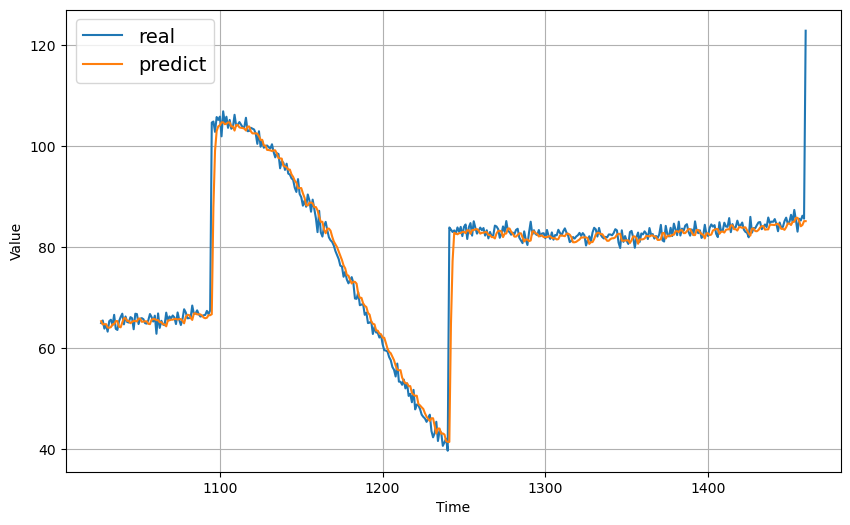

In [46]:
test_predict = []
split_point = int(split_prop * len(series))
test_time = time[split_point+window_size-1:] # 测试集时间 
test_true = series[split_point+window_size-1:] # 测试集真实值
test_predict = net(test_feature).squeeze().tolist() # 测试集预测值

plt.figure(figsize=(10, 6))
plot_series(test_time, test_true, label='real')
plot_series(test_time, test_predict, label='predict')
plt.show()

## CNN-真实数据回归

In [67]:
device = torch.device('cuda:2')

### 数据处理

In [47]:
import pandas as pd

In [80]:
# 读取原始文件，并设置日期为索引
data = pd.read_csv('气温.csv', index_col='DATE', na_values='+9999,9')
# 选取气温列
data = data['TMP']
# 将data_index设置为时间格式
data.index = pd.to_datetime(data.index)
# 设置开始以及结束时间，截取一段
start_time = pd.to_datetime('2019-01-01 00:00:00')
end_time = pd.to_datetime('2019-06-30 23:00:00')
data = data[start_time:end_time]
# 删除NAN值
data = data.dropna()
#转为int型
data = data.str.split(',', expand=True)[0]
data = data.astype('int')/10

# 因为前面有dropNAN，所以要补全缺失的时间点
time = pd.date_range(start_time, end_time, freq='H')
data = data.reindex(time)
data = data.interpolate()
# 转为 array
series = np.array(data)

/tmp/ipykernel_801040/4173772618.py:2: DtypeWarning: Columns (4,6,7,8,9,10,11,12,13,14,17,18,20,21,22,23,25,26,27,28,29,31,32,33,34,35,36,37,39,41,45,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('气温.csv', index_col='DATE', na_values='+9999,9')


### 数据可视化

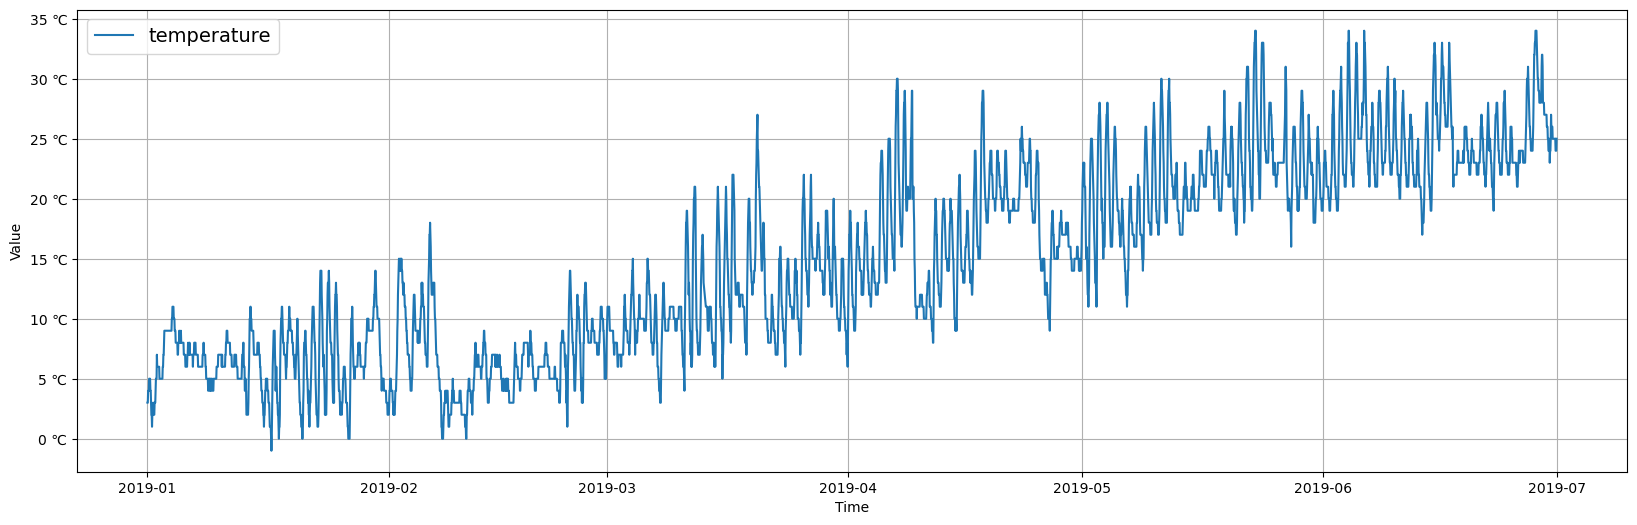

In [53]:
import matplotlib.ticker as mticker

fig,ax = plt.subplots(figsize=(20, 6))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d ℃'))
plot_series(time, series, label='temperature')
plt.show()

### 数据处理

In [81]:
split_prop = 0.7
train, test = train_test_split(series, split_prop)
window_size = 13
# 数据处理
train_feature, train_label, test_feature, test_label = data_process(train, test, window_size)
# 分别输出训练集、测试集的特征和标签
print(train_feature.shape)
print(train_label.shape)
print(test_feature.shape)
print(test_label.shape)

滑窗之前： torch.Size([3040])
滑窗之后： torch.Size([3028, 13])
torch.Size([3028, 1, 12])
torch.Size([3028, 1])
torch.Size([1292, 1, 12])
torch.Size([1292, 1])


### 构建一维卷积神经网络

In [68]:
# 定义卷积神经网络
class ConvModule1(nn.Module):
    def __init__(self):
        super(ConvModule1, self).__init__()
        # 一层一维卷积
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        # 将输出通道变为单值
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        out = self.conv1(x) # 一维卷积
        out = F.max_pool1d(out, kernel_size=2, padding=1) # 最大池化
        out = self.conv2(out) # 一维卷积
        out = F.max_pool1d(out, 3) # 最大池化
        out = out.squeeze()
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
# 构建网络
net = ConvModule1().to(device)

In [69]:
# 定义损失函数-均方误差
def square_loss(feature, label):
    return (net(feature) - label)**2/2

### 参数初始化

In [70]:
for params in net.parameters():
    nn.init.normal_(params, mean=0, std=0.01)

lr = 0.001
num_epochs = 100
batch_size = 128
loss = square_loss
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

### 训练模型

In [71]:
train_loss, test_loss = [], []
# 模型训练
for epoch in range(num_epochs):
    train_l, test_l = 0.0, 0.0
    for X,y in data_iter(batch_size, train_feature, train_label):
        X, y = X.to(device), y.to(device)
        l = loss(X, y).sum() # 计算 loss
        # 梯度清零
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        l.backward() # 反向传播
        optimizer.step() # 更新参数
    
    train_l = loss(train_feature.to(device), train_label.to(device)).mean().detach().item()
    test_l = loss(test_feature.to(device), test_label.to(device)).mean().detach().item()
    train_loss.append(train_l)
    test_loss.append(test_l)
    print('epoch %d, train loss: %f, test loss: %f' % (epoch+1, train_l, test_l))

epoch 1, train loss: 60.904656, test loss: 223.796968
epoch 2, train loss: 5.549660, test loss: 6.273514
epoch 3, train loss: 5.589889, test loss: 6.187866
epoch 4, train loss: 4.992185, test loss: 5.719976
epoch 5, train loss: 4.627632, test loss: 5.694271
epoch 6, train loss: 4.279503, test loss: 5.733398
epoch 7, train loss: 3.853761, test loss: 5.221075
epoch 8, train loss: 3.397029, test loss: 4.516071
epoch 9, train loss: 2.965398, test loss: 3.864096
epoch 10, train loss: 2.549029, test loss: 3.273370
epoch 11, train loss: 2.145242, test loss: 2.699001
epoch 12, train loss: 1.775457, test loss: 2.176524
epoch 13, train loss: 1.461575, test loss: 1.752608
epoch 14, train loss: 1.220413, test loss: 1.430445
epoch 15, train loss: 1.056758, test loss: 1.227130
epoch 16, train loss: 0.954794, test loss: 1.119966
epoch 17, train loss: 0.893076, test loss: 1.069136
epoch 18, train loss: 0.854203, test loss: 1.047486
epoch 19, train loss: 0.799389, test loss: 0.984286
epoch 20, train lo

### 绘制损失函数曲线

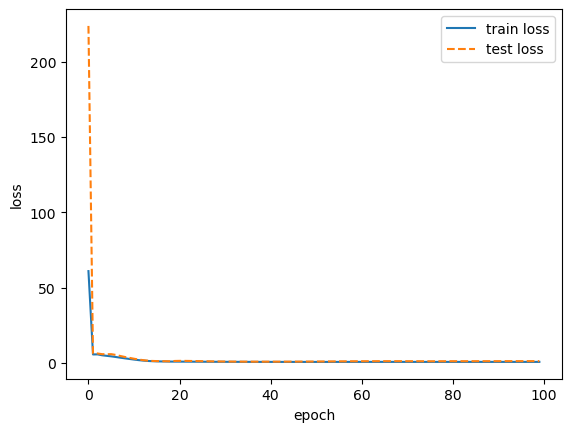

In [75]:
x = np.arange(num_epochs)
plt.plot(x, train_loss, label='train loss')
plt.plot(x, test_loss, label='test loss', linestyle='--')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### 预测并对比

In [72]:
def predict(x):
    temp = torch.from_numpy(x)
    x_tensor = temp.reshape(1, 1, window_size-1) # 一次只输入一个样本
    return net(x_tensor)

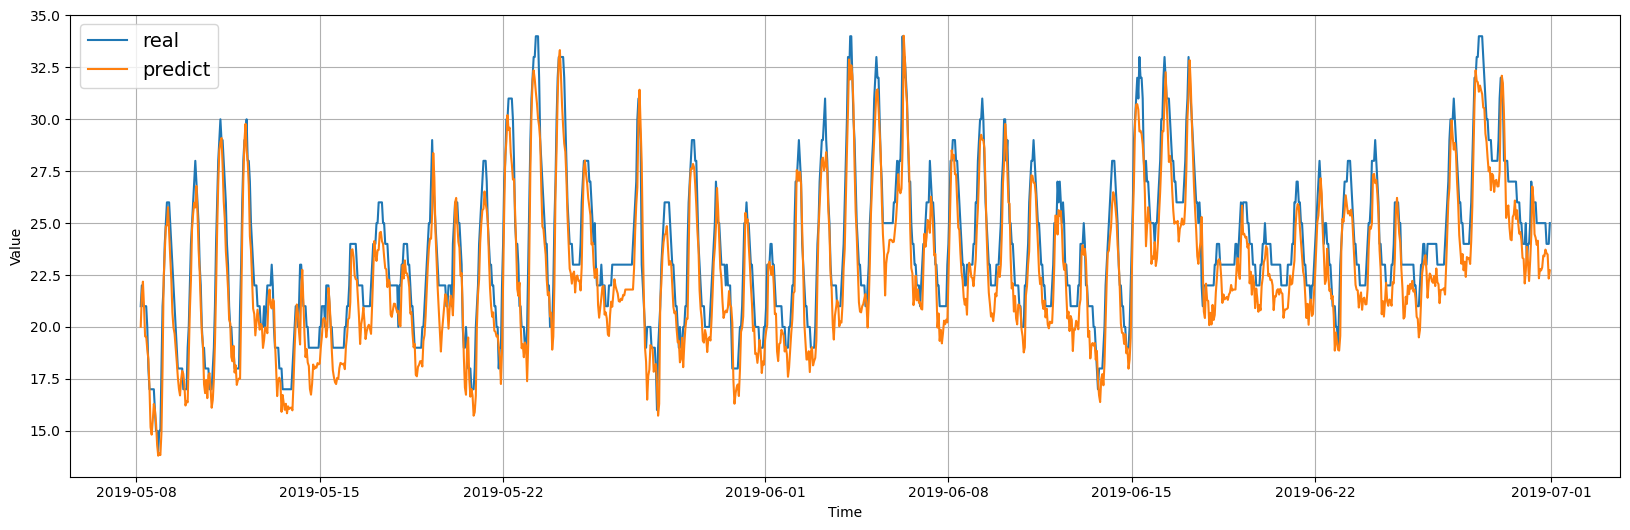

In [76]:
net = net.to('cpu') # 把 net单独拆下来，放到cpu上；要不然就得把数据搬到 GPU 上

test_predict = []
split_point = int(split_prop * len(series))
test_time = time[split_point+window_size-1:] # 测试集时间 
test_true = series[split_point+window_size-1:] # 测试集真实值
test_predict = net(test_feature).squeeze().tolist() # 测试集预测值

plt.figure(figsize=(20, 6))
plot_series(test_time, test_true, label='real')
plot_series(test_time, test_predict, label='predict')
plt.show()